partc)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive # laoding drive where data is mounted
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW5/airline-passengers.csv') #finding data path
data[1:11] #first 10 rows

,Month,Passengers
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119
10,1949-11,104


In [ ]:
data['Month'] = pd.to_datetime(data['Month'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [ ]:
data.set_index('Month', inplace=True)

In [ ]:
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Fix the random number seed to 0 in numpy for reproducibility. 

In [ ]:

np.random.seed(0)

Convert the integer values in the data to ﬂoating point values, which are more suitable for modeling with a neural network.

In [ ]:
data['Passengers'] = data['Passengers'].astype(float)

In [ ]:
data['Passengers']

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
              ...  
1960-08-01    606.0
1960-09-01    508.0
1960-10-01    461.0
1960-11-01    390.0
1960-12-01    432.0
Name: Passengers, Length: 144, dtype: float64

 Normalize the data to range (0,1) since LSTMs are sensitive to the scale of the input data, speciﬁcally when the sigmoid or tanh activation functions are used. You can use the MinMaxScaler function in sklearn. 
 

In [ ]:
data['Passengers']
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1)) 
data=scaler.fit_transform(data)

In [ ]:
data

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

Split the ﬁrst 67% of the data as training data and the remaining 33% as testing data.

In [ ]:
#Creating train and test partition
train = int(len(data)*0.67)
test = len(data)-train # from seprating train from the main data for extracting test data
train_data,test_data=data[0:train,:],data[train:len(data),:1]

Obtain the two-column input-output dataset to be used in LSTM, where the ﬁrst column is the input (number of passengers in the current month) for each instance (i.e., each row), and the second column is the output (number of passengers next month). In this dataset, the values in the ﬁrst column will be the same as the values in the second column of previous row.

In [ ]:
 #array  values to a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

Reshape the input data to be in the [samples, time steps, features] format, which LSTM network expects. The time step will be 1 with this dataset since each monthly sample represents a unit time step. You can use the
1
reshape function in numpy with (Xtrain.shape[0], 1, Xtrain.shape[1]) as the new size, where Xtrain is the training input data. Apply the same reshaping to the test data Xtest. 

In [ ]:
# reshape into X=t and Y=t+1
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
y_train

array([0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984556,
       0.08494208, 0.08494208, 0.06177606, 0.02895753, 0.        ,
       0.02702703, 0.02123552, 0.04247104, 0.07142857, 0.05984556,
       0.04054054, 0.08687259, 0.12741313, 0.12741313, 0.1042471 ,
       0.05598456, 0.01930502, 0.06949807, 0.07915058, 0.08880309,
       0.14285714, 0.11389961, 0.13127413, 0.14285714, 0.18339768,
       0.18339768, 0.15444015, 0.11196911, 0.08108108, 0.11969112,
       0.12934363, 0.14671815, 0.17181467, 0.14864865, 0.15250965,
       0.22007722, 0.24324324, 0.26640927, 0.2027027 , 0.16795367,
       0.13127413, 0.17374517, 0.17760618, 0.17760618, 0.25482625,
       0.25289575, 0.24131274, 0.26833977, 0.30888031, 0.32432432,
       0.25675676, 0.20656371, 0.14671815, 0.18725869, 0.19305019,
       0.16216216, 0.25289575, 0.23745174, 0.25096525, 0.30888031,
       0.38223938, 0.36486486, 0.2992278 , 0.24131274, 0.19111969,
       0.24131274, 0.26640927, 0.24903475, 0.31467181, 0.31853

In [ ]:
X_train

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [ ]:
X_train.shape, y_train.shape


((94, 1), (94,))

In [ ]:
# reshape input to  [sample, time steps, features] which is necessary for LSTM
X_train =X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1] )

X_train.shape

(94, 1, 1)

In [ ]:
y_train.shape

(94,)

Build the LSTM network with a hidden layer of 4 neurons, and an output layer with a single neuron. Use sigmoid activation function in the hidden layer, 100 epochs, batch size of 1, “adam” optimizer, and mean-squarederror loss

In [ ]:
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import Dense,CuDNNLSTM, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math 


model=Sequential()
#model.add(LSTM(4, input_dim=1))#inputlayer
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(4))
model.add(Dense(1))# output layer
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=1,verbose=1)

Epoch 1/100
94/94 [==============================] - 1s 7ms/step - loss: 0.0359 - val_loss: 0.1704
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.1262
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0118 - val_loss: 0.0804
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0616
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0279
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0145
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0104
Epoch 8/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0101
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0103
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0113
Epoch 11/

In [ ]:
X_train.shape, y_train.shape

((94, 1, 1), (94,))

 Predict the next month’s number of passengers and invert the predictions using the “inverse-transform” attribute of MinMaxScaler to go back to the original unit (thousands of passengers per month). 

In [ ]:
#Model Prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)



In [ ]:
#Transforming data back to original form
train_predict=scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict=scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])



Calculate and print the root-mean-squared-error (RMSE) in training and test data. 

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.77 RMSE
Test Score: 53.22 RMSE


 Finally, align and plot the actual and predicted values for the entire dataset including training and testing

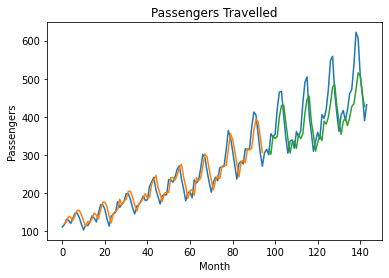

In [ ]:
look_back = 1
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.title("Passengers Travelled")
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()